# Synthetic Tests - Order N

In [ ]:
# =========================
# Cell 1 — Imports
# =========================
import numpy as np
import time
import matplotlib.pyplot as plt

# Optional (faster einsum planner on larger contractions):
# !pip -q install opt_einsum
try:
    import opt_einsum as oe
    USE_OE = True
except Exception:
    USE_OE = False


In [ ]:
# =========================
# Cell 2 — Core utilities
# =========================
def gamma_beta(beta: float) -> float:
    # Paper setting: beta in [0,2)
    if beta < 1.0:
        return 1.0 / (2.0 - beta)
    return 1.0

def beta_divergence(X, Y, beta: float) -> float:
    # entry-wise discrete beta divergence summed over entries
    X = np.asarray(X)
    Y = np.asarray(Y)

    if beta == 1.0:
        # KL
        return float(np.sum(np.where(X > 0, X * np.log(X / Y), 0.0) - X + Y))
    elif beta == 0.0:
        # IS
        return float(np.sum(X / Y - np.log(X / Y) - 1.0))
    else:
        return float(np.sum((X**beta + (beta - 1.0) * Y**beta - beta * X * (Y ** (beta - 1.0)))
                            / (beta * (beta - 1.0))))

def clamp_after_update(A, eps: float):
    return np.maximum(A, eps)

def safe_PQ(X, Xhat, beta: float, eps: float):
    # clamp Xhat only (to avoid 0^(neg power)), but do NOT clamp denominators later
    Xhat = np.maximum(Xhat, eps)
    P = X * (Xhat ** (beta - 2.0))
    Q = (Xhat ** (beta - 1.0))
    return P, Q, Xhat

def _symbols(N: int):
    # supports up to N<=26 for convenience (lowercase for data indices, uppercase for core)
    low = list("abcdefghijklmnopqrstuvwxyz")
    up  = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
    if N > 26:
        raise ValueError("This helper supports tensor order up to 26. (Easy to extend if needed.)")
    return low[:N], up[:N]


_EINSUM_CACHE = {}

def einsum(expr, *operands):
    if USE_OE:
        key = (expr, tuple(op.shape for op in operands))
        fn = _EINSUM_CACHE.get(key)
        if fn is None:
            fn = oe.contract_expression(expr, *[op.shape for op in operands], optimize="optimal")
            _EINSUM_CACHE[key] = fn
        return fn(*operands)
    return np.einsum(expr, *operands, optimize=True)



In [ ]:
# =========================
# Cell 3 — Generic CP ops (any order)
# =========================
RIDX = "R"  # rank index

def cp_reconstruct(factors):
    N = len(factors)
    idx, _ = _symbols(N)
    expr_in = ",".join([f"{idx[n]}{RIDX}" for n in range(N)])
    expr_out = "".join(idx)
    return einsum(expr_in + "->" + expr_out, *factors)

def cp_contr(T, factors, n):
    N = len(factors)
    idx, _ = _symbols(N)
    subs = ["".join(idx)]
    ops  = [T]
    for m in range(N):
        if m == n:
            continue
        subs.append(f"{idx[m]}{RIDX}")
        ops.append(factors[m])
    expr = ",".join(subs) + "->" + f"{idx[n]}{RIDX}"
    return einsum(expr, *ops)



In [ ]:
# =========================
# Cell 4 — Generic Tucker ops (any order)
# =========================
def tucker_reconstruct(core, factors):
    # core: (J1,...,JN), factors[n]: (I_n, J_n)
    N = len(factors)
    i_syms, j_syms = _symbols(N)
    core_sub = "".join(j_syms)
    out_sub  = "".join(i_syms)
    fac_subs = [f"{i_syms[n]}{j_syms[n]}" for n in range(N)]
    expr = core_sub + "," + ",".join(fac_subs) + "->" + out_sub
    return einsum(expr, core, *factors)



def tucker_core_contr(T, factors):
    """
    Compute core = T x_1 A1^T x_2 ... x_N AN^T.
    Accepts factors either as A_n (I_n x R_n) or A_n^T (R_n x I_n),
    and chooses the correct einsum subscripts automatically.
    """
    N = len(factors)
    i_syms, j_syms = _symbols(N)  # i_syms: data-mode indices, j_syms: rank indices

    T_sub = "".join(i_syms)       # e.g. 'abcd'
    core_sub = "".join(j_syms)    # e.g. 'wxyz'

    fac_subs = []
    for n, A in enumerate(factors):
        In = T.shape[n]
        i = i_syms[n]
        j = j_syms[n]

        if A.shape[0] == In:
            # A is (I_n, R_n): use i j
            fac_subs.append(f"{i}{j}")
        elif A.shape[1] == In:
            # A is (R_n, I_n) = A^T: use j i
            fac_subs.append(f"{j}{i}")
        else:
            raise ValueError(
                f"Factor {n} has shape {A.shape}, incompatible with mode-{n} size In={In}."
            )

    expr = T_sub + "," + ",".join(fac_subs) + "->" + core_sub
    return einsum(expr, T, *factors)


def tucker_factor_contr(T, core, factors, n):
    # contraction producing Num/Den for factor n: shape (I_n, J_n)
    N = len(factors)
    i_syms, j_syms = _symbols(N)
    T_sub    = "".join(i_syms)
    core_sub = "".join(j_syms)
    ops = [T, core]
    subs = [T_sub, core_sub]
    for m in range(N):
        if m == n:
            continue
        ops.append(factors[m])
        subs.append(f"{i_syms[m]}{j_syms[m]}")
    expr = ",".join(subs) + "->" + f"{i_syms[n]}{j_syms[n]}"
    return einsum(expr, *ops)


In [ ]:
# =========================
# Cell 5 — Joint-MM transforms (corrected)
# =========================
def chi1(Z, Zt, beta: float):
    # IMPORTANT: corrected exponent (beta-1), not (1-beta)
    return (Zt ** (2.0 - beta)) * (Z ** (beta - 1.0))

def chi2(Z, Zt, beta: float):
    if beta < 1.0:
        return Z
    return (Z ** beta) * (Zt ** (1.0 - beta))


In [ ]:
# Quick sanity: chi1(Z,Z)=Z and chi2(Z,Z)=Z
def sanity_transforms(eps=1e-10):
    Z = np.random.rand(5,5) + 0.1
    for beta in [0.5, 1.0, 1.5]:
        a = chi1(Z, Z, beta)
        b = chi2(Z, Z, beta)
        print(beta, np.max(np.abs(a-Z)), np.max(np.abs(b-Z)))
sanity_transforms()

0.5 2.220446049250313e-16 0.0
1.0 0.0 0.0
1.5 2.220446049250313e-16 2.220446049250313e-16


In [ ]:
# =========================
# Cell 5.1 — Helper for faster computations
# =========================
def mu_update_inplace(A, Num, Den, g, eps, clip_ratio=1e10):
    """A <- max( A * (Num/(Den+eps))^g , eps )  done with minimal temporaries."""
    ratio = Num / (Den + eps)
    if clip_ratio is not None:
        np.clip(ratio, 0.0, clip_ratio, out=ratio)
    np.power(ratio, g, out=ratio)
    A *= ratio
    np.maximum(A, eps, out=A)
    return A

def mu_update_from_ref(Aref, Num, Den, g, eps, clip_ratio=1e10):
    """Anew <- max( Aref * (Num/(Den+eps))^g , eps )  (for Joint-MM reference-based updates)."""
    ratio = Num / (Den + eps)
    if clip_ratio is not None:
        np.clip(ratio, 0.0, clip_ratio, out=ratio)
    np.power(ratio, g, out=ratio)
    Anew = Aref.copy()
    Anew *= ratio
    np.maximum(Anew, eps, out=Anew)
    return Anew


In [ ]:
# =========================
# Cell 6 — Algorithms: CP Block-MM (true block-coordinate MM)
# =========================
def cp_block_mm(X, factors0, beta: float, n_outer=50, eps=1e-12):
    factors = [A.copy() for A in factors0]
    N = len(factors)
    g = gamma_beta(beta)

    losses = []
    times  = []
    t0 = time.perf_counter()

    for it in range(n_outer):
        # true block-MM: recompute (Xhat,P,Q) before each block update
        for n in range(N):
            Xhat = cp_reconstruct(factors)
            P, Q, _ = safe_PQ(X, Xhat, beta, eps)

            Num = cp_contr(P, factors, n)
            Den = cp_contr(Q, factors, n)
            ratio = Num / (Den + eps)
            factors[n] = mu_update_inplace(factors[n], Num, Den, g, eps)


        Xhat = np.maximum(cp_reconstruct(factors), eps)
        losses.append(beta_divergence(X, Xhat, beta))
        times.append(time.perf_counter() - t0)

    return factors, np.array(losses), np.array(times)


In [ ]:
# =========================
# Cell 7 — Algorithms: CP Joint-MM (cached Ptilde/Qtilde)
# =========================
def cp_joint_mm(X, factors0, beta: float, n_outer=50, n_inner=3, eps=1e-12):
    factors = [A.copy() for A in factors0]
    N = len(factors)
    g = gamma_beta(beta)

    losses = []
    times  = []
    t0 = time.perf_counter()

    for it in range(n_outer):
        # reference
        Atilde = [A.copy() for A in factors]
        Xhat_tilde = cp_reconstruct(Atilde)
        Ptilde, Qtilde, _ = safe_PQ(X, Xhat_tilde, beta, eps)

        # inner iterate
        A = [A.copy() for A in Atilde]

        # initialize transformed lists
        A1 = [chi1(A[n], Atilde[n], beta) for n in range(N)]
        A2 = [chi2(A[n], Atilde[n], beta) for n in range(N)]

        for _ in range(n_inner):
            for n in range(N):
                NumJ = cp_contr(Ptilde, A1, n)
                DenJ = cp_contr(Qtilde, A2, n)
                ratio = NumJ / (DenJ + eps)

                A[n] = mu_update_from_ref(Atilde[n], NumJ, DenJ, g, eps)

                # refresh only what changed
                A1[n] = chi1(A[n], Atilde[n], beta)
                A2[n] = chi2(A[n], Atilde[n], beta)

        factors = A

        Xhat = np.maximum(cp_reconstruct(factors), eps)
        losses.append(beta_divergence(X, Xhat, beta))
        times.append(time.perf_counter() - t0)

    return factors, np.array(losses), np.array(times)


In [ ]:
# =========================
# Cell 8 — Algorithms: Tucker Block-MM and Joint-MM
# =========================
def tucker_block_mm(X, core0, factors0, beta: float, n_outer=50, eps=1e-12):
    core = core0.copy()
    factors = [A.copy() for A in factors0]
    N = len(factors)
    g = gamma_beta(beta)

    losses = []
    times  = []
    t0 = time.perf_counter()

    for it in range(n_outer):
        # update factors (true block-coordinate MM)
        for n in range(N):
            Xhat = tucker_reconstruct(core, factors)
            P, Q, _ = safe_PQ(X, Xhat, beta, eps)

            Num = tucker_factor_contr(P, core, factors, n)
            Den = tucker_factor_contr(Q, core, factors, n)
            ratio = Num / (Den + eps)
            factors[n] = mu_update_inplace(factors[n], Num, Den, g, eps)



        # update core (block-coordinate MM)
        Xhat = tucker_reconstruct(core, factors)
        P, Q, _ = safe_PQ(X, Xhat, beta, eps)

        NumG = tucker_core_contr(P, [A.T for A in factors])
        DenG = tucker_core_contr(Q, [A.T for A in factors])
        ratioG = NumG / (DenG + eps)

        core = mu_update_inplace(core, NumG, DenG, g, eps)

        Xhat = np.maximum(tucker_reconstruct(core, factors), eps)
        losses.append(beta_divergence(X, Xhat, beta))
        times.append(time.perf_counter() - t0)

    return core, factors, np.array(losses), np.array(times)


def tucker_joint_mm(X, core0, factors0, beta: float, n_outer=50, n_inner=3, eps=1e-12):
    core = core0.copy()
    factors = [A.copy() for A in factors0]
    N = len(factors)
    g = gamma_beta(beta)

    losses = []
    times  = []
    t0 = time.perf_counter()

    for it in range(n_outer):
        Gt = core.copy()
        At = [A.copy() for A in factors]
        Xhat_tilde = tucker_reconstruct(Gt, At)
        Ptilde, Qtilde, _ = safe_PQ(X, Xhat_tilde, beta, eps)

        G = Gt.copy()
        A = [A.copy() for A in At]

        # init transformed blocks once
        A1 = [chi1(A[n], At[n], beta) for n in range(N)]
        A2 = [chi2(A[n], At[n], beta) for n in range(N)]
        G1 = chi1(G, Gt, beta)
        G2 = chi2(G, Gt, beta)

        for _ in range(n_inner):
            # update factors with GS refresh
            for n in range(N):
                NumJ = tucker_factor_contr(Ptilde, G1, A1, n)
                DenJ = tucker_factor_contr(Qtilde, G2, A2, n)
                ratio = NumJ / (DenJ + eps)

                A[n] = mu_update_from_ref(At[n], NumJ, DenJ, g, eps)

                A1[n] = chi1(A[n], At[n], beta)
                A2[n] = chi2(A[n], At[n], beta)

            # update core (uses transformed factors; core itself excluded from contraction)
            NumG = tucker_core_contr(Ptilde, [B.T for B in A1])
            DenG = tucker_core_contr(Qtilde, [B.T for B in A2])
            ratioG = NumG / (DenG + eps)
            G = mu_update_from_ref(Gt, NumG, DenG, g, eps)

            G1 = chi1(G, Gt, beta)
            G2 = chi2(G, Gt, beta)

        core, factors = G, A


        Xhat = np.maximum(tucker_reconstruct(core, factors), eps)
        losses.append(beta_divergence(X, Xhat, beta))
        times.append(time.perf_counter() - t0)

    return core, factors, np.array(losses), np.array(times)


In [ ]:
# =========================
# Cell 9 — Pretty plots
# =========================
def plot_histories(histories, title):
    plt.style.use("seaborn-v0_8-whitegrid")

    fig = plt.figure(figsize=(12,4))

    ax1 = plt.subplot(1,2,1)
    for name, (loss, tt) in histories.items():
        ax1.plot(loss, label=name, linewidth=2)
    ax1.set_title(title + " — loss vs outer iter")
    ax1.set_xlabel("outer iteration")
    ax1.set_ylabel(r"$D_\beta(X\|\hat X)$")
    ax1.legend()

    ax2 = plt.subplot(1,2,2)
    for name, (loss, tt) in histories.items():
        ax2.plot(tt, loss, label=name, linewidth=2)
    ax2.set_title(title + " — loss vs CPU time")
    ax2.set_xlabel("time (s)")
    ax2.set_ylabel(r"$D_\beta(X\|\hat X)$")
    ax2.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# =========================
# Cell 10 — Baseline MU with unfoldings (CP + Tucker)
# =========================

def unfold_mode(T, n: int):
    """
    Mode-n unfolding consistent with our einsum conventions.
    We use axes order: [n] + [0..N-1 except n] (in increasing order).
    """
    N = T.ndim
    axes = [n] + [m for m in range(N) if m != n]
    return np.transpose(T, axes).reshape(T.shape[n], -1)

def khatri_rao_list(mats):
    """
    Column-wise Khatri–Rao for a list of matrices mats[k] of shape (I_k, R).
    IMPORTANT: the order of mats matters. With our unfolding, CP MTTKRP requires
    KRP over the other factors in *reverse* mode order (see cp_mttkrp_unfold below).
    """
    if len(mats) == 0:
        raise ValueError("khatri_rao_list expects at least one matrix.")
    R = mats[0].shape[1]
    K = mats[0]
    for A in mats[1:]:
        # (I, R) and (M, R) -> (I*M, R), with last matrix varying fastest
        K = (A[:, None, :] * K[None, :, :]).reshape(A.shape[0] * K.shape[0], R)
    return K

def cp_mttkrp_unfold(T, factors, n: int):
    """
    MTTKRP via mode-n unfolding:  T_(n) @ KRP( factors_except_n ).
    For our unfold_mode definition, the KRP order must be reversed(other_modes).
    """
    N = len(factors)
    others = [m for m in range(N) if m != n]
    Tn = unfold_mode(T, n)  # (I_n, prod_{m!=n} I_m)

    # reverse order is crucial for matching the einsum definition
    K = khatri_rao_list([factors[m] for m in reversed(others)])  # (prod I_m, R)
    return Tn @ K

def kron_list(mats):
    """
    Kronecker product of matrices in the given order:
    kron(A1, A2, ..., Ak) = (((A1 ⊗ A2) ⊗ A3) ...).
    With unfold_mode axes order, 'others' in increasing order works.
    """
    if len(mats) == 0:
        return np.array([[1.0]])
    K = mats[0]
    for A in mats[1:]:
        K = np.kron(K, A)
    return K

def tucker_Bn_unfold(core, factors, n: int):
    """
    Build B^{(n)} such that Xhat_(n) = A^{(n)} @ B^{(n)} for Tucker:
      core: (J1,...,JN)
      factors[m]: (I_m, J_m)
    We use:
      B^{(n)} = G_(n) @ kron( A^{(m)} for m!=n )^T
    with 'others' in increasing order for consistency with unfold_mode.
    """
    N = len(factors)
    others = [m for m in range(N) if m != n]

    Gn = unfold_mode(core, n)  # (J_n, prod_{m!=n} J_m)
    K = kron_list([factors[m] for m in others])  # (prod I_m, prod J_m)

    # Bn: (J_n, prod I_m)
    return Gn @ K.T

# -------------------------------------------------
# CP baseline MU (unfolding + Khatri–Rao)
# -------------------------------------------------
def cp_mu_unfolding(X, factors0, beta: float, n_outer=50, eps=1e-12):
    factors = [A.copy() for A in factors0]
    N = len(factors)
    g = gamma_beta(beta)

    losses = []
    times = []
    t0 = time.perf_counter()

    for it in range(n_outer):
        for n in range(N):
            Xhat = cp_reconstruct(factors)
            P, Q, _ = safe_PQ(X, Xhat, beta, eps)

            # unfolding baseline: MTTKRP using P and Q unfoldings
            Num = cp_mttkrp_unfold(P, factors, n)
            Den = cp_mttkrp_unfold(Q, factors, n)

            ratio = Num / (Den + eps)
            factors[n] = clamp_after_update(factors[n] * (ratio ** g), eps)

        Xhat = np.maximum(cp_reconstruct(factors), eps)
        losses.append(beta_divergence(X, Xhat, beta))
        times.append(time.perf_counter() - t0)

    return factors, np.array(losses), np.array(times)

# -------------------------------------------------
# Tucker baseline MU (unfolding + Kronecker)
# -------------------------------------------------
def tucker_mu_unfolding(X, core0, factors0, beta: float, n_outer=50, eps=1e-12):
    core = core0.copy()
    factors = [A.copy() for A in factors0]
    N = len(factors)
    g = gamma_beta(beta)

    losses = []
    times = []
    t0 = time.perf_counter()

    for it in range(n_outer):
        # update factors
        for n in range(N):
            Xhat = tucker_reconstruct(core, factors)
            P, Q, _ = safe_PQ(X, Xhat, beta, eps)

            Pn = unfold_mode(P, n)  # (I_n, prod I_rest)
            Qn = unfold_mode(Q, n)

            Bn = tucker_Bn_unfold(core, factors, n)  # (J_n, prod I_rest)
            # factor update: (I_n x prodI) @ (prodI x J_n) = (I_n x J_n)
            Num = Pn @ Bn.T
            Den = Qn @ Bn.T

            ratio = Num / (Den + eps)
            factors[n] = clamp_after_update(factors[n] * (ratio ** g), eps)

        # update core (use mode-0 unfolding formula: core_(0) = A0^T * P_(0) * kron(A1,...,AN)^ )
        Xhat = tucker_reconstruct(core, factors)
        P, Q, _ = safe_PQ(X, Xhat, beta, eps)

        P0 = unfold_mode(P, 0)  # (I0, prod I_rest)
        Q0 = unfold_mode(Q, 0)

        K = kron_list([factors[m] for m in range(1, N)])  # (prod I_rest, prod J_rest)

        Num0 = factors[0].T @ P0 @ K  # (J0, prod J_rest)
        Den0 = factors[0].T @ Q0 @ K

        NumG = Num0.reshape(core.shape)  # (J0,J1,...,JN)
        DenG = Den0.reshape(core.shape)

        ratioG = NumG / (DenG + eps)
        core = clamp_after_update(core * (ratioG ** g), eps)

        Xhat = np.maximum(tucker_reconstruct(core, factors), eps)
        losses.append(beta_divergence(X, Xhat, beta))
        times.append(time.perf_counter() - t0)

    return core, factors, np.array(losses), np.array(times)


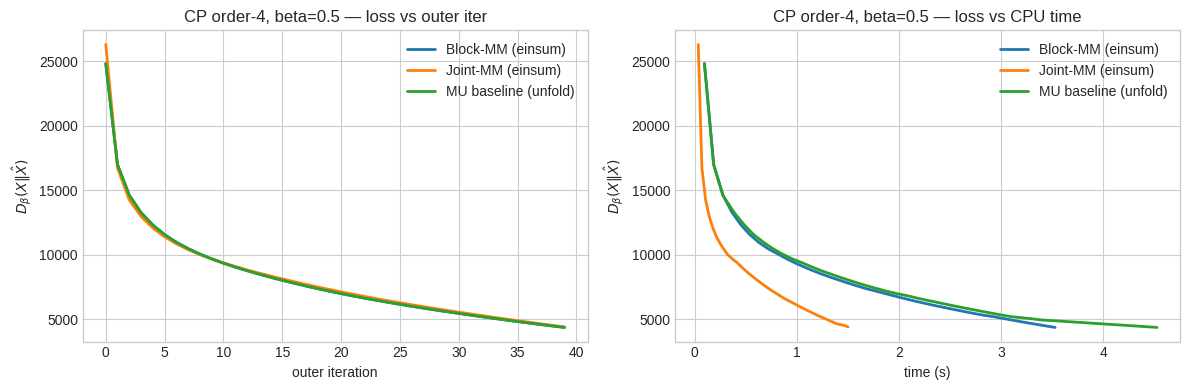

In [ ]:
# =========================
# Cell 11 — Order-4 demo (CP + Tucker), pick any beta in [0,2)
# =========================
rng = np.random.default_rng(0)

# ---- CP ground truth (order 4)
shape = (30, 26, 22, 18)
R = 8
# eps = 1e-12
eps = np.float32(1e-12)
beta = 0.5   # try 0.5, 1.0, 1.5

A_true = [rng.random((shape[n], R)) + 1e-3 for n in range(4)]
X = cp_reconstruct(A_true) + 1e-3

# init
A0 = [rng.random((shape[n], R)) + 1e-3 for n in range(4)]

X  = X.astype(np.float32)
A0 = [A.astype(np.float32) for A in A0]

# run
_, loss_b, t_b = cp_block_mm(X, A0, beta=beta, n_outer=40, eps=eps)
_, loss_j, t_j = cp_joint_mm(X, A0, beta=beta, n_outer=40, n_inner=1, eps=eps)

# CP
# A0_cp = [rng.random((shape[n], R)) + 1e-3 for n in range(4)]
_, loss_mu, t_mu = cp_mu_unfolding(X, A0, beta=beta, n_outer=40, eps=eps)

plot_histories(
    {"Block-MM (einsum)": (loss_b, t_b),
     "Joint-MM (einsum)": (loss_j, t_j),
     "MU baseline (unfold)": (loss_mu, t_mu)},
    title=f"CP order-4, beta={beta}"
)




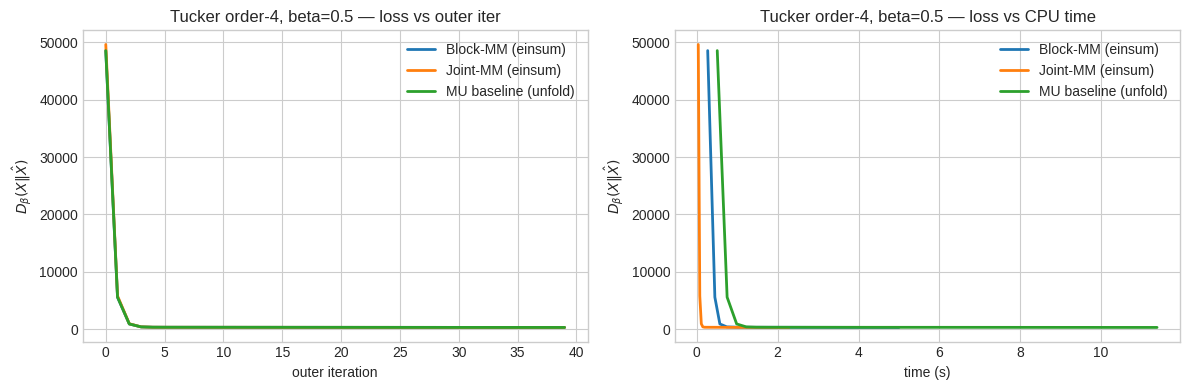

In [ ]:
# =========================
# Cell 12 — Order-4 demo (Tucker)
# =========================


rng = np.random.default_rng(1)

shape = (30, 26, 22, 18)
ranks = (8, 7, 6, 5)
# eps = 1e-12
eps = np.float32(1e-12)
beta = 0.5   # try 0.5, 1.0, 1.5

G_true = rng.random(ranks) + 1e-3
A_true = [rng.random((shape[n], ranks[n])) + 1e-3 for n in range(4)]
X = tucker_reconstruct(G_true, A_true) + 1e-3

# init
G0 = rng.random(ranks) + 1e-3
A0 = [rng.random((shape[n], ranks[n])) + 1e-3 for n in range(4)]

X  = X.astype(np.float32)
A0 = [A.astype(np.float32) for A in A0]
# Tucker:
G0 = G0.astype(np.float32)

# run
_, _, loss_b, t_b = tucker_block_mm(X, G0, A0, beta=beta, n_outer=40, eps=eps)
_, _, loss_j, t_j = tucker_joint_mm(X, G0, A0, beta=beta, n_outer=40, n_inner=1, eps=eps)


# Tucker
# A0_tk = [rng.random((shape[n], ranks[n])) + 1e-3 for n in range(4)]
_, _, loss_mu, t_mu = tucker_mu_unfolding(X, G0, A0, beta=beta, n_outer=40, eps=eps)



plot_histories(
    {"Block-MM (einsum)": (loss_b, t_b),
     "Joint-MM (einsum)": (loss_j, t_j),
     "MU baseline (unfold)": (loss_mu, t_mu)},
    title=f"Tucker order-4, beta={beta}"
)


# Include competitors "einfact"

https://github.com/jhood3/einfact

In [ ]:
!pip -q install opt_einsum
# torch is usually already in Colab; if not:
# !pip -q install torch

!wget -q https://raw.githubusercontent.com/jhood3/einfact/main/einfact.py -O einfact.py



In [ ]:
import pathlib, re, importlib

p = pathlib.Path("einfact.py")
txt = p.read_text()

# (i) fix NameError: device -> self.device
txt = txt.replace("str(device)", "str(self.device)")

# (ii) disable the internal 5% validation split (train on all observed entries)
txt = txt.replace(
    "val_selector = torch.rand(initial_mask_bool.shape, device=self.device) < 0.05",
    "val_selector = torch.zeros(initial_mask_bool.shape, device=self.device, dtype=torch.bool)"
)

p.write_text(txt)

import einfact
importlib.reload(einfact)
from einfact import NNEinFact



In [ ]:
import torch
from opt_einsum import contract, contract_path

def nneinfact_set_params(model, params_np, clamp=1e-10):
    """
    params_np: list of numpy arrays matching model.param_strs order.
    Rebuild cached paths and Y_hat after setting params.
    """
    assert len(params_np) == len(model.param_strs), "Wrong number of params for this model."

    model.P_params = [
        torch.as_tensor(np.maximum(P, clamp), device=model.device, dtype=torch.float32)
        for P in params_np
    ]

    # recompute cached paths and current Y_hat
    model.y_path = contract_path(model.model_str, *model.P_params)[0]
    model.Y_hat = contract(model.model_str, *model.P_params, optimize=model.y_path).clamp(min=clamp)

    model.einsum_str = [einfact.swap(model.model_str, i) for i in range(len(model.P_params))]
    model.contract_paths = [None] * len(model.P_params)
    for i in range(len(model.P_params)):
        others = [model.P_params[j] for j in range(len(model.P_params)) if j != i] + [model.Y_hat]
        model.contract_paths[i] = contract_path(model.einsum_str[i], *others, memory_limit=1e10)[0]


In [ ]:
from einfact import NNEinFact

# =========================
# Cell 11 — Order-4 demo (CP + Tucker), pick any beta in [0,2)
# =========================
rng = np.random.default_rng(0)

# ---- CP ground truth (order 4)
shape = (60, 52, 44, 36)
R = 8
eps = 1e-12
beta = 1.5   # try 0.5, 1.0, 1.5

# map your beta-divergence to einfact (alpha,beta)
alpha_einfact = 1.0
beta_einfact  = beta - 1.0

A_true = [rng.random((shape[n], R)) + 1e-3 for n in range(4)]
X = cp_reconstruct(A_true) + 1e-3

A0 = [rng.random((shape[n], R)) + 1e-3 for n in range(4)]


X  = X.astype(np.float32)
A0 = [A.astype(np.float32) for A in A0]


# run your methods
_, loss_b, t_b = cp_block_mm(X, A0, beta=beta, n_outer=40, eps=eps)
_, loss_j, t_j = cp_joint_mm(X, A0, beta=beta, n_outer=40, n_inner=1, eps=eps)
_, loss_mu, t_mu = cp_mu_unfolding(X, A0, beta=beta, n_outer=40, eps=eps)

# run NNEinFact
model_str  = "ar,br,cr,dr->abcd"
(I1, I2, I3, I4) = shape
shape_dict = {"a": I1, "b": I2, "c": I3, "d": I4, "r": R}


model = NNEinFact("ar,br,cr,dr->abcd", shape_dict=shape_dict,
                  alpha=alpha_einfact, beta=beta_einfact, device="cpu")

# same init as your A0
nneinfact_set_params(model, A0, clamp=1e-10)

hist = model.fit(X, max_iter=40, verbose=False, mask=np.ones_like(X, dtype=bool))


loss_e = np.array(hist["loss"], dtype=float)
t_e    = np.array(hist["time"], dtype=float)








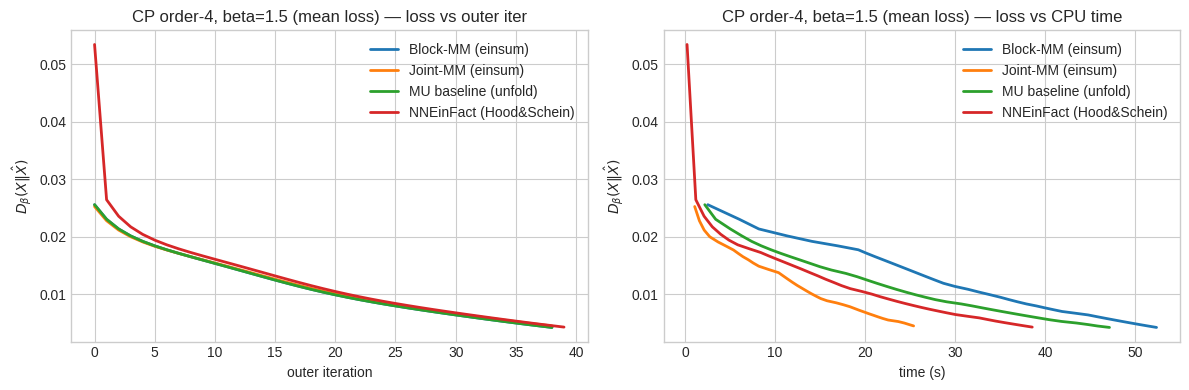

In [ ]:
scale = X.size
loss_b_m  = loss_b / scale
loss_j_m  = loss_j / scale
loss_mu_m = loss_mu / scale

plot_histories(
    {"Block-MM (einsum)": (loss_b_m[1:], t_b[1:]),
     "Joint-MM (einsum)": (loss_j_m[1:], t_j[1:]),
     "MU baseline (unfold)": (loss_mu_m[1:], t_mu[1:]),
     "NNEinFact (Hood&Schein)": (loss_e[1:], t_e[1:])},
    title=f"CP order-4, beta={beta} (mean loss)"
)

In [ ]:
# =========================
# Cell — Order-4 demo (Tucker + NNEinFact)
# =========================
from einfact import NNEinFact
import numpy as np
import time

rng = np.random.default_rng(1)

shape = (60, 52, 44, 36)          # bigger like your CP test
ranks = (8, 7, 6, 5)
eps = 1e-12
beta = 1.5                        # try 0.5, 1.0, 1.5

# map your beta-divergence (beta in [0,2)) to einfact (alpha,beta_ab)
alpha_einfact = 1.0
beta_einfact  = beta - 1.0

# ---- ground truth Tucker
G_true = rng.random(ranks) + 1e-3
A_true = [rng.random((shape[n], ranks[n])) + 1e-3 for n in range(4)]
X = tucker_reconstruct(G_true, A_true) + 1e-3

# init
G0 = rng.random(ranks) + 1e-3
A0 = [rng.random((shape[n], ranks[n])) + 1e-3 for n in range(4)]

X  = X.astype(np.float32)
A0 = [A.astype(np.float32) for A in A0]
# Tucker:
G0 = G0.astype(np.float32)

# run your methods
_, _, loss_b, t_b   = tucker_block_mm(X, G0, A0, beta=beta, n_outer=40, eps=eps)
_, _, loss_j, t_j   = tucker_joint_mm(X, G0, A0, beta=beta, n_outer=40, n_inner=1, eps=eps)
_, _, loss_mu, t_mu = tucker_mu_unfolding(X, G0, A0, beta=beta, n_outer=40, eps=eps)

# run NNEinFact Tucker
# Tucker model: ia,jb,kc,ld,abcd->ijkl
model_str  = "ia,jb,kc,ld,abcd->ijkl"
I1, I2, I3, I4 = shape
J1, J2, J3, J4 = ranks
shape_dict = {
    "i": I1, "j": I2, "k": I3, "l": I4,
    "a": J1, "b": J2, "c": J3, "d": J4
}


model = NNEinFact("ia,jb,kc,ld,abcd->ijkl", shape_dict=shape_dict,
                  alpha=alpha_einfact, beta=beta_einfact, device="cpu")

params0 = [A0[0], A0[1], A0[2], A0[3], G0]   # IMPORTANT order
nneinfact_set_params(model, params0, clamp=1e-10)

hist = model.fit(X, max_iter=40, verbose=False, mask=np.ones_like(X, dtype=bool))


loss_e = np.array(hist["loss"], dtype=float)
t_e    = np.array(hist["time"], dtype=float)




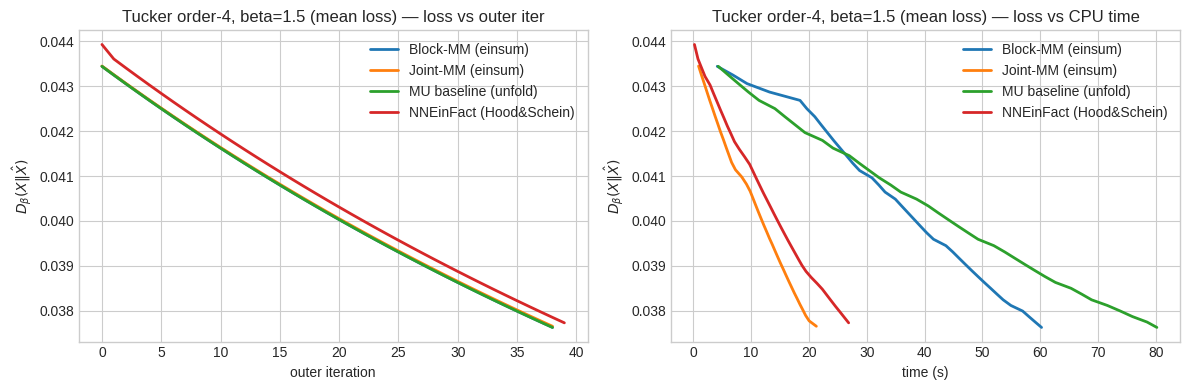

In [ ]:
# ---- plot mean-loss for apples-to-apples with NNEinFact
scale = X.size
loss_b_m  = loss_b  / scale
loss_j_m  = loss_j  / scale
loss_mu_m = loss_mu / scale

plot_histories(
    {"Block-MM (einsum)": (loss_b_m[1:], t_b[1:]),
     "Joint-MM (einsum)": (loss_j_m[1:], t_j[1:]),
     "MU baseline (unfold)": (loss_mu_m[1:], t_mu[1:]),
     "NNEinFact (Hood&Schein)": (loss_e[1:], t_e[1:])},
    title=f"Tucker order-4, beta={beta} (mean loss)"
)